In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from datetime import datetime, date

In [2]:
# Center Images
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Problem Description

As a financial institution regulated by the FCA, Revolut has the obligation to verify the identity of all customers who want to open a Revolut account. 

Each prospective customer has to go through a Know Your Customer (KYC) process by submitting a government-issued photo ID and a facial picture of themself to our partner, Veritas. Veritas then would perform 2 checks:

• Document check: To verify that the photo ID is valid and authentic;

• Facial Similarity check: To verify that the face in the picture is the same as that on the submitted ID.

The customer will ‘pass’ the KYC process and get onboarded if the results of both Document and Facial Similarity checks are ‘clear’. If the result of any check is not ‘clear’, the customer has to submit all the photos again. 

The “pass rate” is defined as the number of customers who pass both the KYC process divided by the number of customers who attempt the process. Each customer has up to 2 attempts.

The pass rate has decreased substantially in the recent period.

Find the root causes and solutions.

## Data

In [3]:
# Load Data
facial = pd.read_csv('facial_similarity_reports.csv', index_col=0)
doc = pd.read_csv('doc_reports.csv', index_col=0)

In [4]:
facial.head()

,user_id,result,face_comparison_result,created_at,facial_image_integrity_result,visual_authenticity_result,properties,attempt_id
0,ab23fae164e34af0a1ad1423ce9fd9f0,clear,clear,2017-06-20T23:12:58Z,clear,consider,{},050a0596de424fab83c433eaa18b3f8d
1,15a84e8951254011b47412fa4e8f65b8,clear,clear,2017-06-20T23:16:04Z,clear,clear,{},f69c1e5f45a64e50a26740b9bfb978b7
2,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,2017-06-20T17:59:49Z,clear,clear,{},f9f84f3055714d8e8f7419dc984d1769
3,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,2017-06-20T17:59:39Z,clear,clear,{},10a54a1ecf794404be959e030f11fef6
4,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,2017-06-20T18:08:09Z,clear,clear,{},1f320d1d07de493292b7e0d5ebfb1cb9


In [5]:
doc.head()

,user_id,result,visual_authenticity_result,image_integrity_result,face_detection_result,image_quality_result,created_at,supported_document_result,conclusive_document_quality_result,colour_picture_result,data_validation_result,data_consistency_result,data_comparison_result,attempt_id,police_record_result,compromised_document_result,properties,sub_result
0,ab23fae164e34af0a1ad1423ce9fd9f0,consider,consider,clear,clear,clear,2017-06-20T23:12:57Z,clear,NaN,NaN,clear,clear,NaN,050a0596de424fab83c433eaa18b3f8d,clear,NaN,"{'gender': 'Male', 'nationality': 'IRL', 'docu...",caution
1,15a84e8951254011b47412fa4e8f65b8,clear,clear,clear,clear,clear,2017-06-20T23:16:04Z,clear,NaN,NaN,clear,NaN,NaN,f69c1e5f45a64e50a26740b9bfb978b7,clear,NaN,"{'gender': 'Female', 'document_type': 'driving...",clear
2,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,clear,clear,clear,2017-06-20T17:59:49Z,clear,NaN,NaN,clear,clear,NaN,f9f84f3055714d8e8f7419dc984d1769,clear,NaN,"{'gender': 'Male', 'nationality': 'ITA', 'docu...",clear
3,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,clear,clear,clear,2017-06-20T17:59:38Z,clear,NaN,NaN,clear,clear,NaN,10a54a1ecf794404be959e030f11fef6,clear,NaN,"{'gender': 'Male', 'issuing_date': '2007-08', ...",clear
4,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,clear,clear,clear,2017-06-20T18:08:09Z,clear,NaN,NaN,clear,clear,NaN,1f320d1d07de493292b7e0d5ebfb1cb9,clear,NaN,"{'gender': 'Male', 'nationality': 'POL', 'docu...",clear


In [6]:
# Deal with the feature properties
properties_doc = doc['properties'].map(eval).apply(pd.Series) # Stackoverflow tip
doc = pd.concat([doc.drop(['properties'], axis=1), properties_doc], axis=1)

properties_facial = facial['properties'].map(eval).apply(pd.Series) # Stackoverflow tip
facial = pd.concat([facial.drop(['properties'], axis=1), properties_facial], axis=1)

# These lines of code take 1,5 min to run

In [7]:
# Transform to date_time format
facial['created_at'] = pd.to_datetime(facial['created_at'])
doc['created_at'] = pd.to_datetime(doc['created_at'])
doc['date_of_expiry'] = pd.to_datetime(doc['date_of_expiry'], errors='coerce')
doc['issuing_date'] = pd.to_datetime(doc['issuing_date'], errors='coerce')

In [8]:
dfs = {'Facial DF': facial, 'Docs DF': doc} # create a dictionary to loop the df's

In [9]:
# Data Frames Description
for name, df in dfs.items():
    print(f'Name: {name} \n')
    print(f'Shape: {df.shape}\n')
    print(f'Columns: {df.columns}\n')
    print(f'Null Values: \n{df.isnull().sum()} \n')
    print(f'Unique Values: \n{df.nunique()} \n')
    print(f'Duplicated Values: \n{df.duplicated().any()}\n')
    print(f'Data Type: \n{df.dtypes} \n')
    print(f'Range Period: \nMin: {df.created_at.min()}, Max: {df.created_at.max()}\n')
    print('-----------------------\n')

Name: Facial DF 

Shape: (176404, 8)

Columns: Index(['user_id', 'result', 'face_comparison_result', 'created_at',
       'facial_image_integrity_result', 'visual_authenticity_result',
       'attempt_id', 'score'],
      dtype='object')

Null Values: 
user_id                               0
result                                1
face_comparison_result            10397
created_at                            0
facial_image_integrity_result       463
visual_authenticity_result        26114
attempt_id                            0
score                            172921
dtype: int64 

Unique Values: 
user_id                          142724
result                                2
face_comparison_result                2
created_at                       169820
facial_image_integrity_result         2
visual_authenticity_result            2
attempt_id                       176404
score                                79
dtype: int64 

Duplicated Values: 
False

Data Type: 
user_id               

##### Comment: The lenght of both df's are the same, we have two colums in common in both dfs (user_id and attempt_id), we have lots of null values . We have no duplicated rows within the df

In [10]:
# It was seen that the Gender has 5 unique values:
doc['gender'].value_counts()

Male      78397
Female    41536
8             3
MALE          1
FEMALE        1
Name: gender, dtype: int64

In [11]:
# Replace Gender values
doc['gender'] = doc['gender'].replace(['FEMALE','MALE','8'],['Female','Male','Male'])

In [12]:
# See if column user_id and attempt_id are the same in both dfs. Possible merge? 
print(facial['user_id'].equals(doc['user_id']))
print(facial['attempt_id'].equals(doc['attempt_id']))

True
False


In [13]:
# See which attempt_id are different
print(list(set(facial['attempt_id']) - set(doc['attempt_id'])), list(set(doc['attempt_id']) - set(facial['attempt_id'])))

for f, d in zip(list(facial['attempt_id']), list(doc['attempt_id'])):
    if f != d:
        print(f, d)

['96948966045741509980950989095520'] ['9.6949E+31']
96948966045741509980950989095520 9.6949E+31


In [14]:
# Correct floating format
doc.replace('9.6949E+31', '96948966045741509980950989095520', inplace=True)

In [15]:
# In order to merge, and since there are features with the same name, let's rename them
facial.rename(columns={col: col + '_f' for col in facial.columns if col not in ['user_id', 'attempt_id']}, inplace=True) #facial df columns
doc.rename(columns={col: col + '_d' for col in doc.columns if col not in ['user_id', 'attempt_id']}, inplace=True) # documents df columns

In [16]:
# Merge and sort
df = facial.merge(doc, on=['user_id', 'attempt_id']) # Merge
df = df.sort_values('created_at_f').reset_index(drop=True) # Sort

##### From the pdf file given:
The customer will ‘pass’ the KYC process and get onboarded if the results of both Document
and Facial Similarity checks are ‘clear’. If the result of any check is not ‘clear’, the customer has
to submit all the photos again.

In [17]:
# Create a "pass" feature - 1 if both facial result and documents result are 'clear', 0 otherwise
df['pass'] = np.where((df['result_f'] == 'clear') & (df['result_d'] == 'clear'), 1, 0)

In [18]:
# Create an ordinal count of attempts per user -> n_of_attempt feature, to see each user attempt's count
df['n_of_attempt'] = df.groupby('user_id').cumcount() + 1

In [19]:
df.head()

,user_id,result_f,face_comparison_result_f,created_at_f,facial_image_integrity_result_f,visual_authenticity_result_f,attempt_id,score_f,result_d,visual_authenticity_result_d,...,gender_d,nationality_d,document_type_d,date_of_expiry_d,issuing_country_d,issuing_date_d,issuing_state_d,document_version_d,pass,n_of_attempt
0,3aee7324dfba466d96888ff9ad185b58,clear,clear,2017-05-23 15:13:02+00:00,clear,clear,d21de828c5514277aaedb316edc6c48c,0.73,clear,clear,...,Male,NaN,driving_licence,2027-01-05,GBR,NaT,NaN,NaN,1,1
1,206b6bd0cc114844b471fb750e1c9b8c,consider,NaN,2017-05-23 15:18:05+00:00,consider,clear,b92d851b2380442cbe373c33f1c9dc44,NaN,clear,clear,...,Male,MLT,national_identity_card,2026-01-30,MLT,NaT,NaN,NaN,0,1
2,8edd77f60f8e4a739f35cb797b292e6d,consider,NaN,2017-05-23 15:22:16+00:00,consider,clear,b21d5797e8864adbb215182218094cfb,NaN,clear,clear,...,NaN,NaN,driving_licence,2024-10-21,ESP,NaT,NaN,NaN,0,1
3,636fb441d54446a8996e3ff79e09535f,clear,clear,2017-05-23 15:27:06+00:00,clear,clear,63485edd8dca4d25b95d1dd4484b3bd6,0.79,consider,clear,...,Female,PRT,national_identity_card,2021-03-20,PRT,NaT,NaN,NaN,0,1
4,fffa227d01064f9f9cef396d893863c1,clear,clear,2017-05-23 15:27:56+00:00,clear,clear,c991888dc7c044f2bfdfe058c3aaa45d,0.58,clear,clear,...,Male,NaN,driving_licence,2022-11-29,GBR,NaT,NaN,NaN,1,1


In [20]:
# See time difference between facial report and document report creation from each attempt
(df['created_at_f'] - df['created_at_d']).value_counts()

0 days 00:00:00      167121
0 days 00:00:01        5775
-1 days +23:59:59      3507
-1 days +23:59:56         1
dtype: int64

In [21]:
# See if the users' different attempts are very sparsed in time
temp_ = df.copy()

#Facial reports
result_f = temp_.groupby('user_id').agg({'created_at_f': ['min', 'max']})
print((result_f[('created_at_f', 'max')] - result_f[('created_at_f', 'min')]).value_counts(sort=True).tail())

# Document Reports
result_d = temp_.groupby('user_id').agg({'created_at_d': ['min', 'max']})
print((result_d[('created_at_d', 'max')] - result_d[('created_at_d', 'min')]).value_counts(sort=True).tail())

0 days 13:33:24     1
0 days 01:29:10     1
6 days 00:28:05     1
41 days 01:02:29    1
1 days 00:25:32     1
dtype: int64
0 days 05:20:50     1
0 days 20:03:34     1
19 days 03:53:50    1
0 days 22:50:36     1
1 days 00:25:32     1
dtype: int64


##### Comment: The maximum interval between submission of facial and document report is 4s (don't see any abnormal behaviour in this). The users attempts are also mainly in the same day, with three users doing attempts on different days for facial reports (1, 6 and 41(!) days difference) and two users on different days for documents reports (1 and 19 days). A question arises. If the users submit the photos at the same time, why this incoherence?

## EDA

Text(0.5, 1.0, 'Nº of attempts')

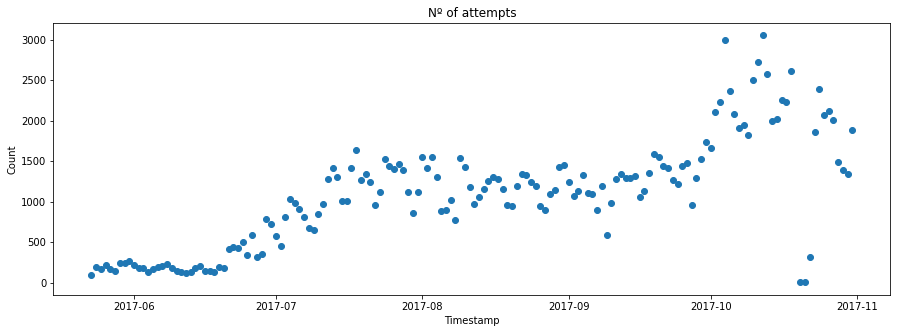

In [22]:
# See if the bussiness is growing. Plot number of attempts along the year
plt.figure(figsize=(15,5))
n_attempts = df.groupby(df['created_at_f'].dt.date)['attempt_id'].count()
plt.scatter(n_attempts.index, n_attempts)
plt.ylabel("Count")
plt.xlabel("Timestamp")
plt.title('Nº of attempts')

##### Comment: We can see an increase number of attempts along the year. Let's see the pass rate

### Dive deeper into the pass rate

In [23]:
# Compute the total pass rate of the given range period (May-23 2017 - Oct-30 2017)
total_users = df['user_id'].nunique() # total number of users
users_attempts = df.groupby(['user_id'])['attempt_id'].count() # nº of attempts by each user

In [24]:
print(total_users) # number of total different users
print(users_attempts.sort_values(ascending=False)) # number of attempts/user

142724
user_id
2df96cd3537d415a9e7f23f419197187    6
6eeb7dbdf1fa4e7c95413bc0608dd21c    6
0749e4cc340c45f3aae46080318fcc0b    5
79c7b0bab8d54d3cb9b2eaccef744c9d    5
3b0a8e16846b4d779c5ba9e5499391af    5
                                   ..
60c3dbf838db401d9b8266bf52f19241    1
60c27165fde5424b82666cf76b3285cc    1
60c267e83acc4426be641f70e6ce62fe    1
60c264391ebc4d45801b1f216fc83273    1
ffffb23498da427595799b6ecda5f70b    1
Name: attempt_id, Length: 142724, dtype: int64


There may be the following scenarios to consider, in order to compute the pass rate:
- A user can pass at the 1st/2nd attempt and stop submitting
- A user can pass at the 1st/2nd attempt and continue submitting (why a customer would do that?)
- A user can fail at the 1st/2nd attempt and stop submitting
- A user can fail at the 1st/2nd attempt and continue submitting (the customer should not be able to, since "Each customer has up to 2 attempts")

Let's confirm:
- if a user fail at the 1st and 2nd attempt, if he tries to submit, will not be able to submit again/ will fail, and it will count as 0 for the pass rate
- if a user passes at the 3rd or more attempt (he continued submitting), he also succeeded in the 1st and 2nd -> it will count as 1 for the pass rate

In [25]:
# Confirm the two points above

temp = df[df['user_id'].map(users_attempts) > 2] # dataframe with users who attempted more than twice
user_pass_more_2 = temp[(temp['n_of_attempt']>2) & (temp['pass'] == 1)]['user_id'] # users who passed after the 2nd attempt
temp_ = df[df['user_id'].isin(user_pass_more_2)] # df with users who passed after the 2nd attempt
temp_[temp_['pass']==0]['n_of_attempt'].value_counts()

1    342
2     65
3      4
4      2
Name: n_of_attempt, dtype: int64

In [26]:
temp_[(temp_['pass']==0) & (temp_['n_of_attempt']==2)].iloc[[0,-1]] # See examples of users that didn't pass the 2nd attempt

,user_id,result_f,face_comparison_result_f,created_at_f,facial_image_integrity_result_f,visual_authenticity_result_f,attempt_id,score_f,result_d,visual_authenticity_result_d,...,gender_d,nationality_d,document_type_d,date_of_expiry_d,issuing_country_d,issuing_date_d,issuing_state_d,document_version_d,pass,n_of_attempt
989,e0bb9eec6bc64173bc62bf6e89e05df3,consider,consider,2017-05-28 23:38:10+00:00,clear,clear,f955c5b0cee44b9ca85f18a4fef089a7,0.47,clear,clear,...,Female,NaN,driving_licence,2023-03-07,GBR,NaT,NaN,NaN,0,2
171696,4c4620f7a8374371987a91216c554575,consider,NaN,2017-10-28 21:21:41+00:00,consider,clear,88f97d45b8954a9bb155ea22a3c5d6b5,NaN,clear,clear,...,Male,NaN,national_identity_card,NaT,FRA,2005-07-01,NaN,NaN,0,2


In [27]:
# Small Test to see if a user really has only just 2 attempts
df[(df['user_id']=='e0bb9eec6bc64173bc62bf6e89e05df3')|(df['user_id']=='4c4620f7a8374371987a91216c554575')][['user_id', 'attempt_id', 'pass', 'n_of_attempt']]

,user_id,attempt_id,pass,n_of_attempt
988,e0bb9eec6bc64173bc62bf6e89e05df3,837cca7f44a544cd826b5b59c938e91a,0,1
989,e0bb9eec6bc64173bc62bf6e89e05df3,f955c5b0cee44b9ca85f18a4fef089a7,0,2
1378,e0bb9eec6bc64173bc62bf6e89e05df3,fc06e6821bee4be88206ce948023b637,1,3
171692,4c4620f7a8374371987a91216c554575,2ae60b680b524f38807f610e3b11b06b,0,1
171696,4c4620f7a8374371987a91216c554575,88f97d45b8954a9bb155ea22a3c5d6b5,0,2
171698,4c4620f7a8374371987a91216c554575,a6e4249024244b3d99319bb26aad2b1b,1,3


### Afterwards a customer can submit (and pass) after 2 failures attempts. Examples were just found.
( Maybe didn't understood the citation - "Each customer has up to 2 attempts" )

It was also noted that, for example, for the user e0bb9eec6bc64173bc62bf6e89e05df3 the customer changed the document type and document's issuing country at the 3rd attempt (when passed). This customer also updated the nationality at the last submission 

But for the user 4c4620f7a8374371987a91216c554575, these facts are not verified

##### Let's compute the pass rate as said in the instructions file given:
The “pass rate” is defined as the number of customers who pass both the KYC process divided
by the number of customers who attempt the process.
The pass rate has decreased substantially in the recent period.
Let's try to find out the root causes (our main focus)

In [28]:
# Pass rate not followin the logic of "Each customer has up to 2 attempts" due to the what was seen above

n_customers_attempt = df['user_id'].nunique() # number of unique users

user_pass = df.groupby(['user_id'])['pass'].max() # group by user pass / not pass
n_customers_pass = len(user_pass[user_pass==1]) # filter by users that passed
pass_rate = n_customers_pass / n_customers_attempt # rate
print(f'Overall pass rate: {round(pass_rate*100,2)} %')

Overall pass rate: 85.09 %


In [29]:
# Just to see if pass rate is very different with the logic of "Each customer has up to 2 attempts"

pass_1st_2nd = df[(df['n_of_attempt'] == 1) | (df['n_of_attempt'] == 2) ] # Customers who pass in the 1st or 2nd attempt
user_pass_1st_2nd = pass_1st_2nd.groupby(['user_id'])['pass'].max() # group by user pass / not pass within the 1st or 2nd attempt
n_customers_pass_1st_2nd = len(user_pass_1st_2nd[user_pass_1st_2nd==1]) # filter by users that passed
pass_rate_1st_2nd = n_customers_pass_1st_2nd / n_customers_attempt # rate
print(f'Overall pass rate: {round(pass_rate_1st_2nd*100,2)} %')

Overall pass rate: 85.05 %


##### Comment: The overall pass rate is not very different considering one logic or other. It also tells that the number of users that passed after the 1st and 2ns failed attempts is very small

In [30]:
# Function to compute the overall, face and documents report pass_rate
def pass_rate(df, column):
    
    '''Compute the overall, face and documents report pass_rate
    
    Args:
            df     (dataframe)     : Final dataframe 
            column (str)           : str with the feature result
        
    Returns:
            2 lists: pass rate and timestamp for plotting'''
    
    temp = df.copy() # create a copy of the dataframe
    temp['created_at_f'] = temp['created_at_f'].dt.date # Transform to date
    temp = temp.replace(['clear', 'consider', 'unidentified'],[1, 0, 0]) # Replace result values to ordinal
    
    # Just smooth the data for a better analysis - drop dates where the number of attempts was too small comparing with the 
    #surrouding values - 2017-10-20, 2017-10-21, 2017-10-22
    temp = temp[(temp['created_at_f'] < pd.Timestamp('2017-10-20')) | (temp['created_at_f'] > pd.Timestamp('2017-10-22'))]
    
    # Create two list to plot
    date_rate = [] #Empty list to store the rate pass values
    timestamp = [] #Empty list to store the timestamp value
    
    #Group by date and user_id and retrieve the maximum value (it will be one if passed, 0 if not)
    pass_time = temp.groupby(['created_at_f', 'user_id'])[column].max().to_frame().reset_index() 

    # Compute the pass rate for each timestamp
    for date in pd.unique(pass_time.created_at_f): # loop through each unique timestamp
        temp_ = temp[temp['created_at_f']==date] # create a temporary df with the iterative variable
        n_pass = temp_.loc[temp_[column] == 1, column].count() # count the number of pass in each timestamp
        rate = n_pass / len(temp_) # pass rate
        date_rate.append(rate)
        timestamp.append(date)
        
    
    return date_rate, timestamp

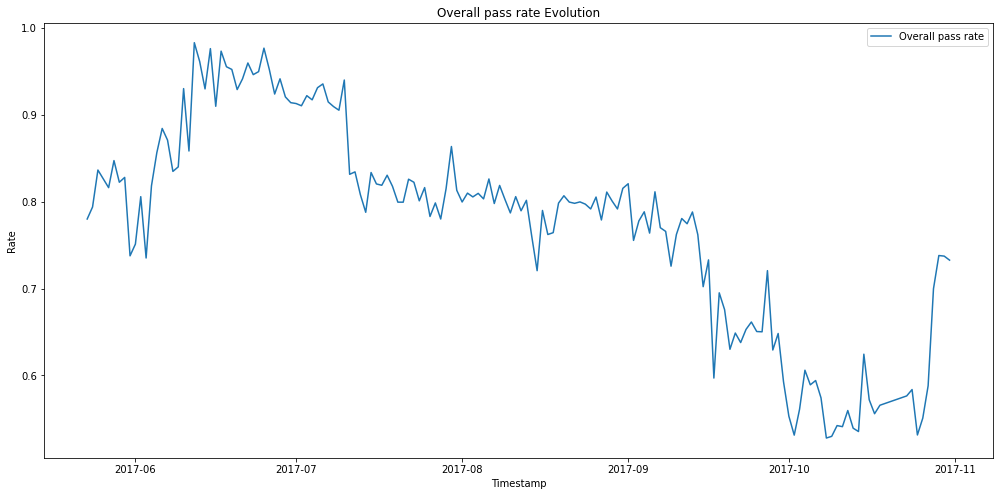

In [31]:
date_rate_ov, timestamp_ov = pass_rate(df, 'pass') # overall pass rate

# Plot Overall pass rate
plt.figure(figsize=(17,8))
plt.plot(timestamp_ov, date_rate_ov, label='Overall pass rate')
plt.title('Overall pass rate Evolution')
plt.ylabel("Rate")
plt.xlabel("Timestamp")
plt.legend()

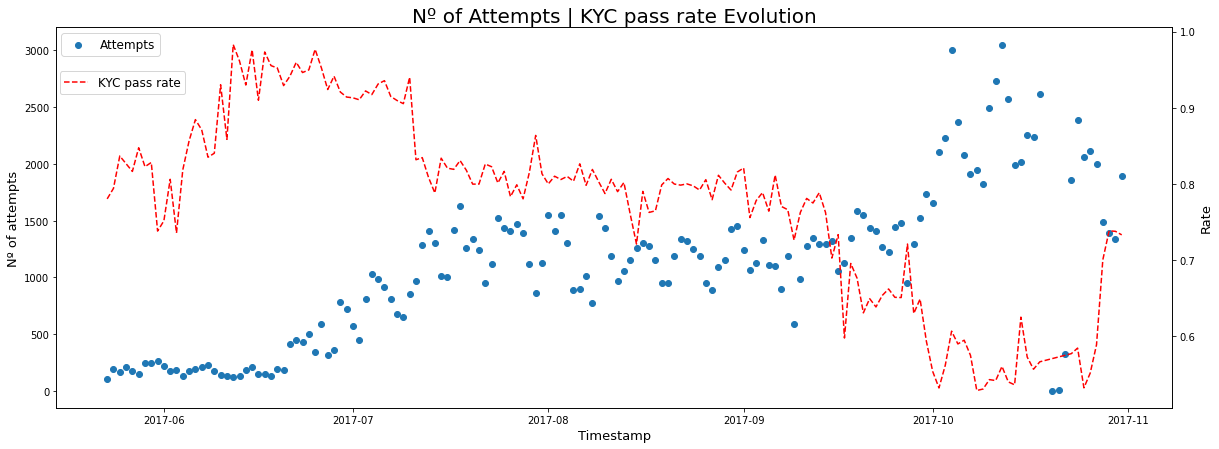

In [48]:
# Combine nº of attempts and pass rate in the same graph
fig,ax = plt.subplots(figsize=(20,7))
n_attempts = df.groupby(df['created_at_f'].dt.date)['attempt_id'].count()
ax.scatter(n_attempts.index, n_attempts, label='Attempts')
ax.set_ylabel("Nº of attempts", fontsize=13)
ax.set_xlabel("Timestamp", fontsize=13)
ax.legend(bbox_to_anchor = (0.098, 1), fontsize=12)
ax2=ax.twinx()
ax2.plot(timestamp_ov, date_rate_ov, label='KYC pass rate', color='red', ls='--')
ax2.set_title('Nº of Attempts | KYC pass rate Evolution', fontsize=20)
ax2.set_ylabel("Rate", fontsize=13)
ax2.set_xlabel("Timestamp")
ax2.legend(bbox_to_anchor = (0.121, 0.9), fontsize=12)
plt.show()

##### Comment: The pass rate is deacresing, with sharp descreases in mid July, mid September and end of September. However, we can also see a sharp increase by the end of October

### Let's try to find out why

Text(0.5, 1.0, 'Results Document Report')

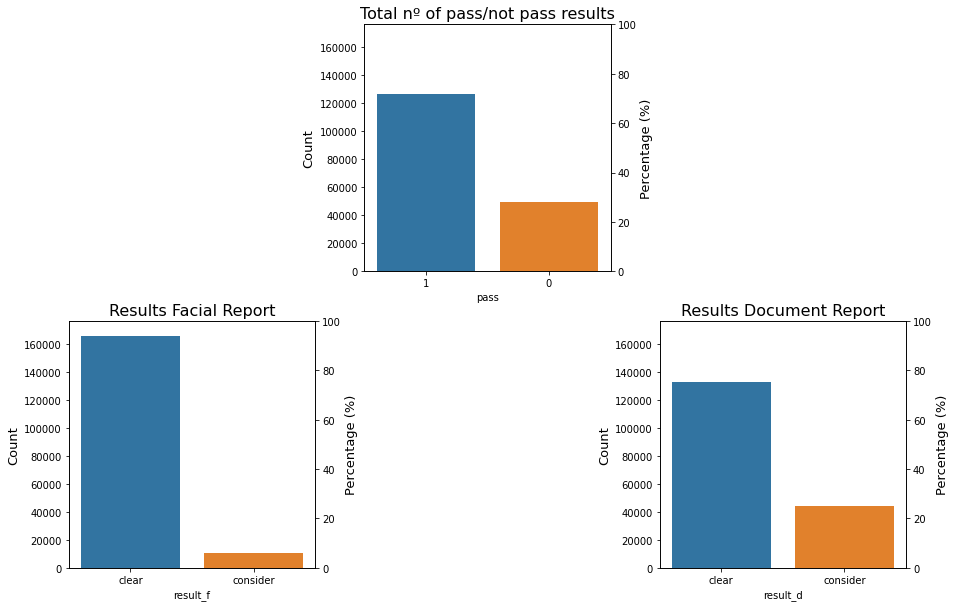

In [52]:
# Plot results from pass feature (both facial and documents results 'clear') and results from facial and documents reports
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(nrows=2, ncols=3)

ax0 = fig.add_subplot(gs[0, 1])
sns.countplot(x = 'pass', data=df, order=[1,0], ax=ax0) 
plt.ylim(0, df['pass'].value_counts().sum()) # coherent scale
plt.ylabel("Count", fontsize=13)
ax0_ = ax0.twinx() # create a secondary axe with the percentage for a more complete reading
ax0_.set_ylim(0,100)
ax0_.set_ylabel('Percentage (%)', fontsize=13)
plt.title('Total nº of pass/not pass results', fontsize=16)

ax1 = fig.add_subplot(gs[1, 0])
sns.countplot(x='result_f', data=df, order=['clear', 'consider'], ax=ax1)
plt.ylim(0, df['result_f'].value_counts().sum()) # coherent scale
plt.ylabel("Count", fontsize=13)
ax1_ = ax1.twinx() # create a secondary axe with the percentage for a more complete reading
ax1_.set_ylim(0,100)
ax1_.set_ylabel('Percentage (%)', fontsize=13)
plt.title('Results Facial Report', fontsize=16)

ax2 = fig.add_subplot(gs[1, 2])
sns.countplot(x="result_d", data=df, order=['clear', 'consider'], ax=ax2)
plt.ylim(0, df['result_d'].value_counts().sum()) # coherent scale
plt.ylabel("Count", fontsize=13)
ax2_ = ax2.twinx() # create a secondary axe with the percentage for a more complete reading
ax2_.set_ylim(0,100)
ax2_.set_ylabel('Percentage (%)', fontsize=13)
plt.title('Results Document Report', fontsize=16)


##### Comment: From this first analysis we start to see the Documents Reports' results may be influencing more the 'pass rate' than the facial reports
- The percentage of the Total pass / not pass results (1st graph) cannot be considerer as the pass rate (see pass rate a few cells below)
- Facial reports' results, with more than 160.000 clear outcomes ~= 90%
- Documents reports' results, with around 130.000 clear outcomes ~= total count of pass outcomes. In this case, the same logic for the (consider,not pass) pair outcome

### Facial results
Athough it is not the main root cause of the decreasing of the pass rate, let's just have an idea of it

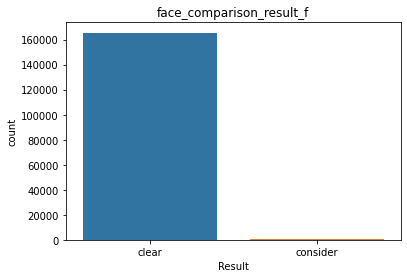

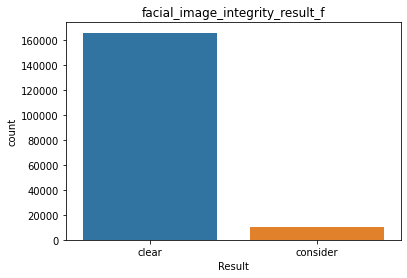

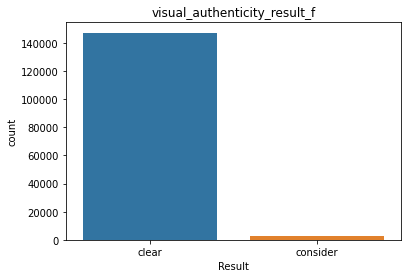

Text(0.5, 1.0, 'Score')

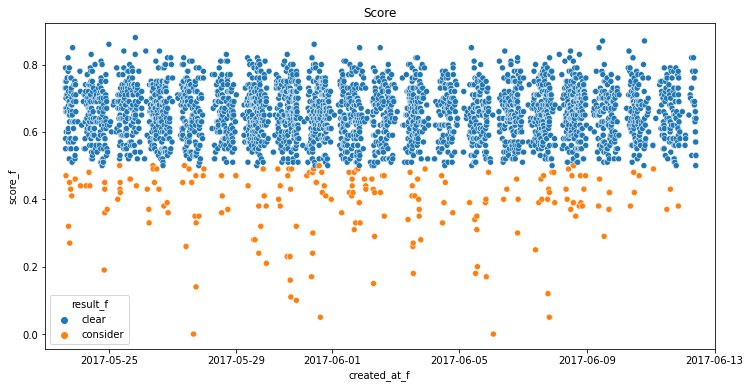

In [34]:
# Features of Facial report
facial_cols = ['face_comparison_result_f', 'facial_image_integrity_result_f', 
               'visual_authenticity_result_f']

# Plot features of Facial report
for col in facial_cols:
    sns.countplot(x = col, data=df)
    plt.title(col)
    plt.xlabel('Result')
    plt.show()

# Plot score results of Facial report
plt.figure(figsize=(12,6))
scatter = sns.scatterplot(x='created_at_f', y='score_f', hue='result_f', data=df)
scatter.set_xlim(left=pd.Timestamp('2017-05-23'), right=pd.Timestamp('2017-06-13'))
plt.title('Score')

##### Comment: It seems that what is influencing more the success rate of the facial reports is the 'facial_image_integrity_result'. We can also see that above 0.5 facial score, the customer usually pass. If image integrity fails, the score property will not be present.

### Docs results

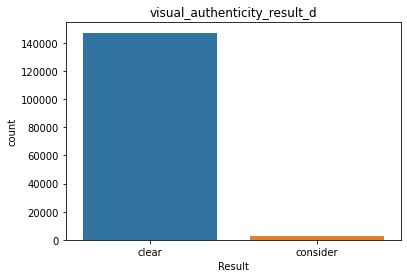

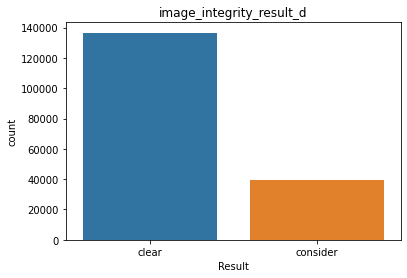

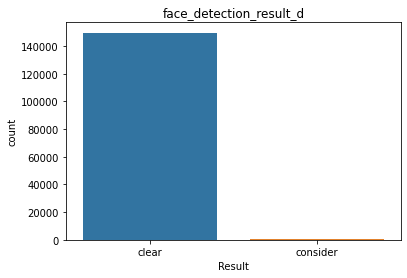

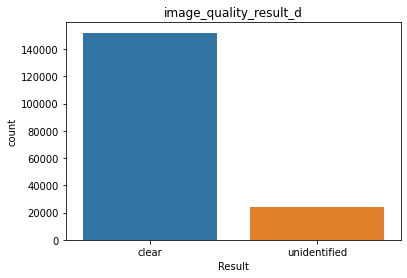

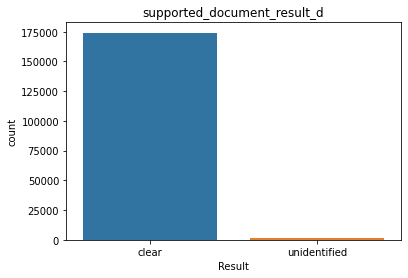

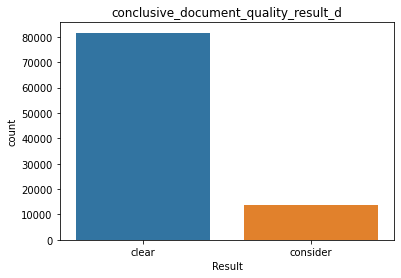

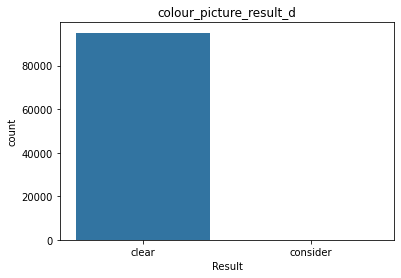

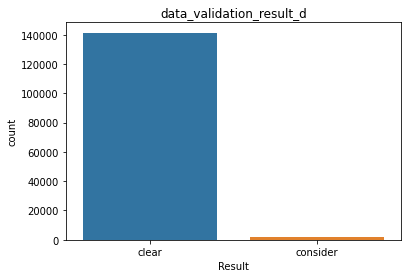

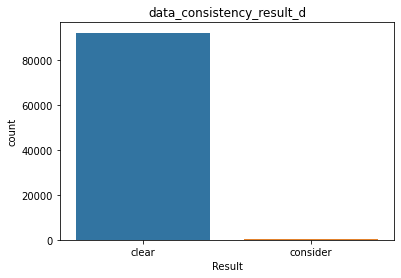

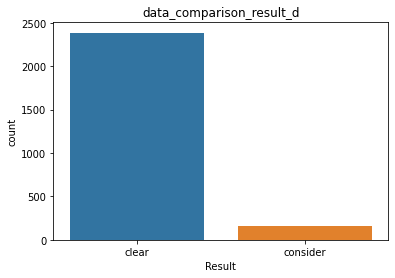

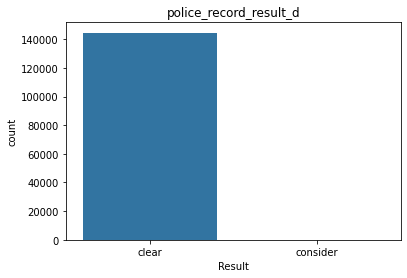

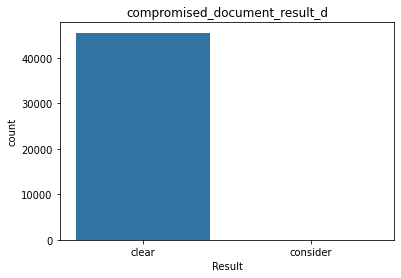

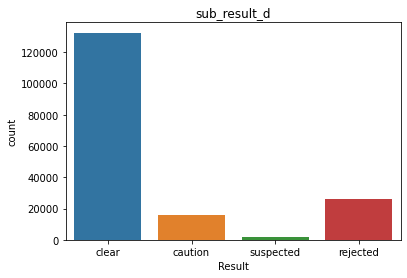

In [35]:
# Features of Facial report
doc_cols = ['visual_authenticity_result_d', 'image_integrity_result_d', 'face_detection_result_d', 'image_quality_result_d', 
            'supported_document_result_d', 'conclusive_document_quality_result_d', 'colour_picture_result_d', 
            'data_validation_result_d', 'data_consistency_result_d', 'data_comparison_result_d', 'police_record_result_d',
            'compromised_document_result_d', 'sub_result_d']

# Plot features of Facial report
for col in doc_cols:
    sns.countplot(x = col, data=df)
    plt.title(col)
    plt.xlabel('Result')
    plt.show()

##### Comment: It seems that what is influencing more the success rate of the document reports is the  'image_integrity_result', 'image_quality_result', 'conclusive_document_quality_result', 'data_comparison_result'

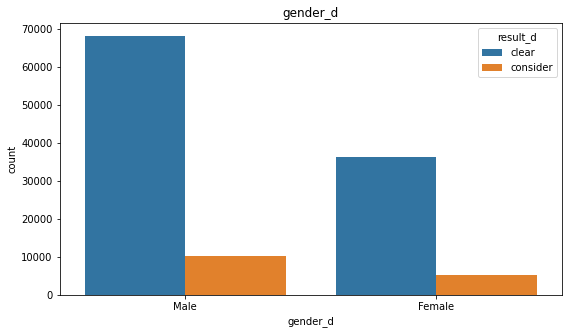

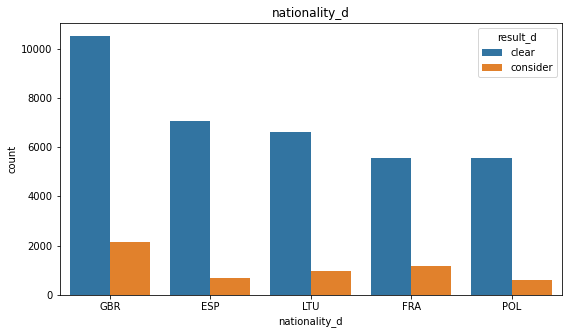

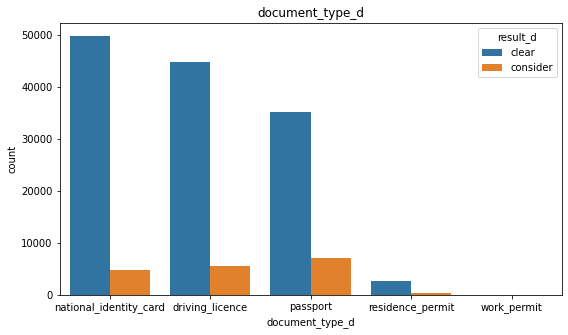

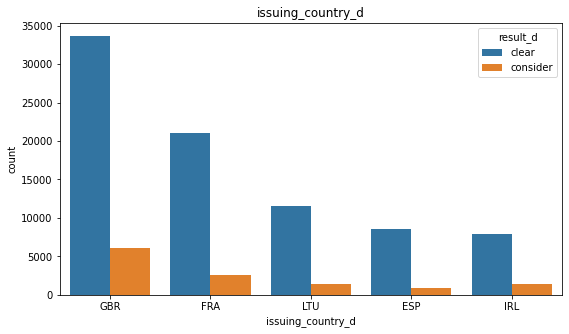

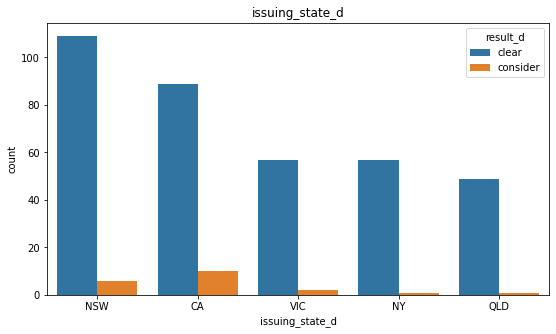

In [36]:
# Other Features of Document Reports
doc_other_cols = ['gender_d', 'nationality_d', 'document_type_d', 'issuing_country_d', 
                 'issuing_state_d']

# Plot Features of Document Reports
for col in doc_other_cols:
    plt.figure(figsize=(9,5))
    sns.countplot(x = col, hue = 'result_d', data=df, order=df[col].value_counts().iloc[:5].index)
    plt.title(col)
    plt.show()

##### Comment: From this analysis we can't infer any direct cause for the decrease of the pass rate

### We have seen what it seems to be influencing more the pass rate. But are those features directly correlated with the decrease of the pass rate? 

#### Let's find out

Text(0.5, 1.0, "Reports' Results Analysis")

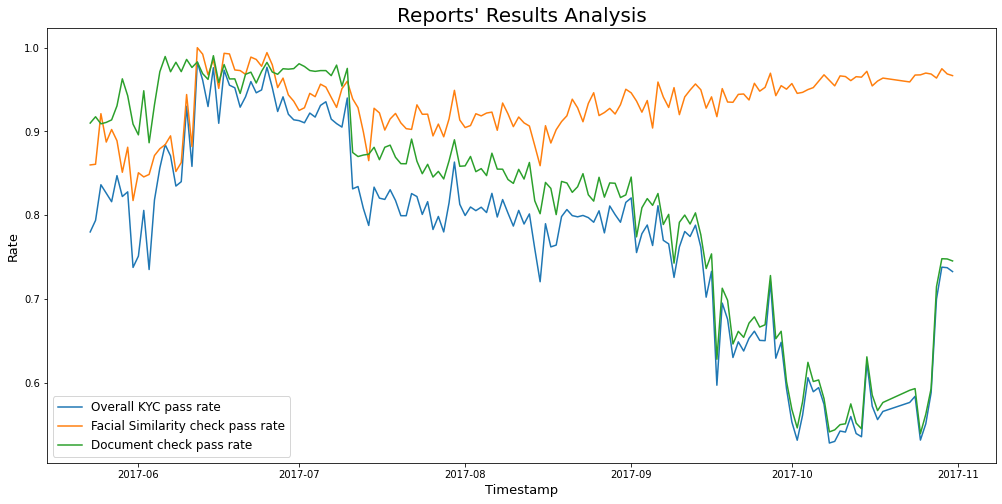

In [37]:
# Plot overall pass rate with facial report and documents report pass rate
date_rate_f, timestamp_f = pass_rate(df, 'result_f')
date_rate_d, timestamp_d = pass_rate(df, 'result_d')

plt.figure(figsize=(17,8))
plt.plot(timestamp_ov, date_rate_ov, label='Overall KYC pass rate')
plt.plot(timestamp_f, date_rate_f, label='Facial Similarity check pass rate')
plt.plot(timestamp_d, date_rate_d, label='Document check pass rate')
plt.legend(fontsize=12)
plt.xlabel('Timestamp', fontsize=13)
plt.ylabel('Rate', fontsize=13)
plt.title("Reports' Results Analysis", fontsize=20)

##### Comment: Finally (!) we can clearly see that the documents results is directly affecting the overall pass rate. 

- At the beginning the overall pass rate was most affected by the facial reports, but by middle of July, it became more affected by the documents result

Text(0.5, 1.0, 'Document check Sub-Results')

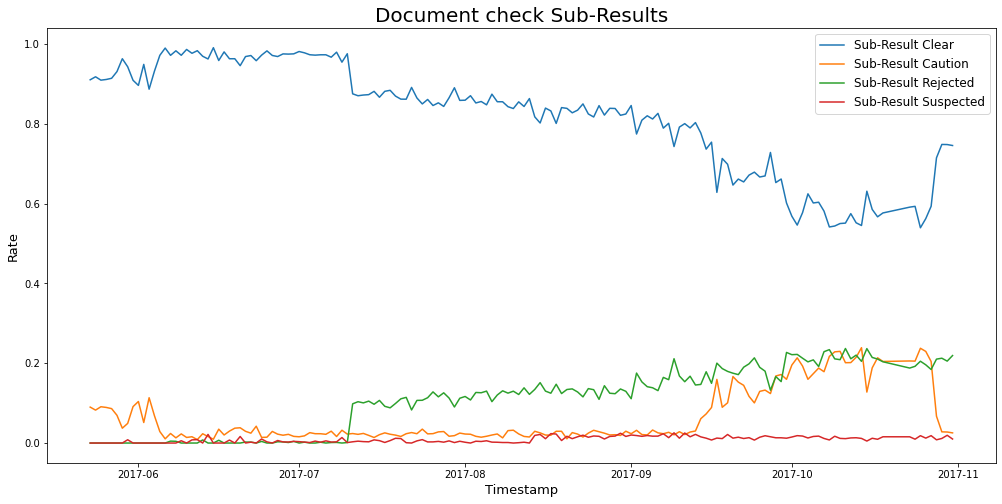

In [50]:
# Plot Document report sub-result
temp = df.copy()
temp = pd.get_dummies(temp, columns=['sub_result_d'])

date_rate_clear, timestamp_clear = pass_rate(temp, 'sub_result_d_clear')
date_rate_caution, timestamp_caution = pass_rate(temp, 'sub_result_d_caution')
date_rate_rejected, timestamp_rejected = pass_rate(temp, 'sub_result_d_rejected')
date_rate_suspected, timestamp_suspected = pass_rate(temp, 'sub_result_d_suspected')

plt.figure(figsize=(17,8))
plt.plot(timestamp_clear, date_rate_clear, label='Sub-Result Clear')
plt.plot(timestamp_caution, date_rate_caution, label='Sub-Result Caution')
plt.plot(timestamp_rejected, date_rate_rejected, label='Sub-Result Rejected')
plt.plot(timestamp_suspected, date_rate_suspected, label='Sub-Result Suspected')
plt.xlabel('Timestamp', fontsize=13)
plt.ylabel('Rate', fontsize=13)
plt.legend(fontsize=12)
plt.title('Document check Sub-Results', fontsize=20)

##### Comment:
- It can be seen that the Clear sub-result pass rate is influenced by the Caution and Rejected sub-results
- In June we can see a decrease in the Clear sub-result due to an increse of the Caution sub-result
- In July there is a sharp decrease in the Clear sub-result due to an increase of the Rejected sub-result
- In September there is also a sharp decrease due to the Rejected and Caution sub-results combined
- The overall pass rate is a little below than the Clear sub-result also due to the facial reports result

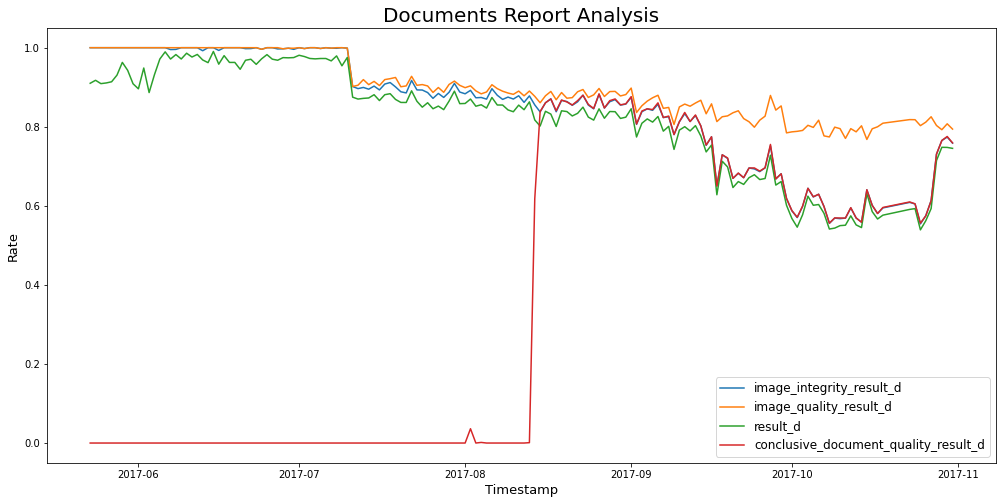

In [39]:
# Plot other relevant features from the analysis of the barplots above

cols = ['image_integrity_result_d', 'image_quality_result_d', 'result_d', 'conclusive_document_quality_result_d'] 
        #'data_comparison_result_d' -> too many null values

plt.figure(figsize=(17,8))
for col in cols:
    date_rate, timestamp = pass_rate(df, col)
    plt.plot(timestamp, date_rate, label=col)
plt.legend(loc = 'lower right', fontsize=12)
plt.title('Documents Report Analysis', fontsize=20)
plt.xlabel('Timestamp', fontsize=13)
plt.ylabel('Rate', fontsize=13)
plt.show()

##### Comment:
- It can be seen that the documents reports' results are diretly influenced by the three features ploted
- From the Veritas API the conclusive_document_quality and image quality are part of the image_integrity report
- At the same time the conclusive_document_quality_result decreases (mid September) the sub-result "caution" increased
- At the same time the image_quality_result and image_integrity_result decreased (July) the sub-result "Rejected" increased

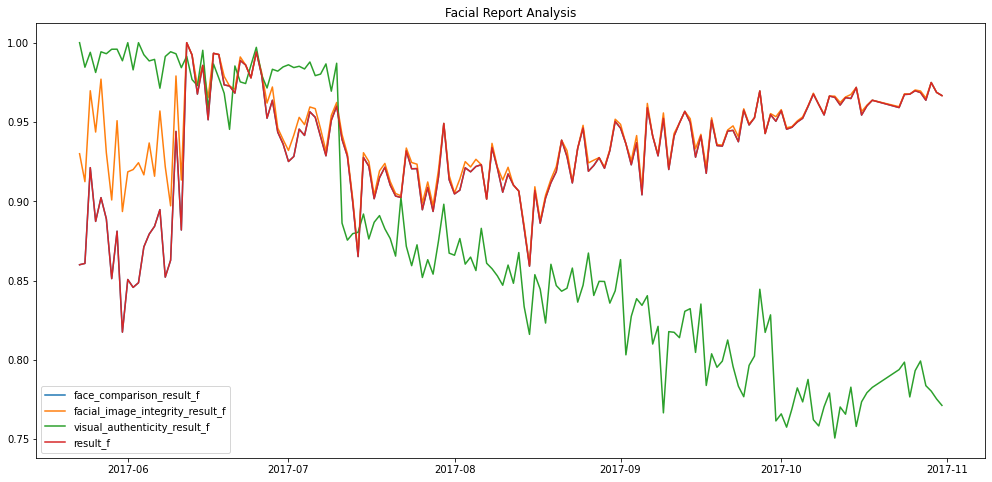

In [40]:
# And finally, plot Facial report most relevant features from the analysis of the barplots above

cols = ['face_comparison_result_f', 'facial_image_integrity_result_f', 'visual_authenticity_result_f', 'result_f']

plt.figure(figsize=(17,8))
for col in cols:
    date_rate, timestamp = pass_rate(df, col)
    plt.plot(timestamp, date_rate, label=col)
plt.legend()
plt.title('Facial Report Analysis')
plt.show()

##### Comment:
- It can be seen that the facial reports' results are diretly influenced by the facial_image_integrity